In [1]:
%load_ext autoreload
%autoreload 2
from dnafiber.postprocess import refine_segmentation
from dnafiber.deployment import run_one_file, ENSEMBLE, Models
from dnafiber.data.utils import convert_rgb_to_mask
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from dnafiber.utils import DEFAULT_CMAP
import logging
import pandas as pd
import seaborn as sns
from dnafiber.analysis.ratios import (
    create_swarm_plot,
    create_violin_plot,
    create_boxen_plot,
    create_boxen_swarmplot,
    load_experiment,
    load_experiment_predictions,
    graders_statistical_test,
    compare_pairs
)

from tqdm.auto import tqdm  
for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True


/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-09-02 14:53:02.024 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-02 14:53:02.890 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-09-02 14:53:02.891 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
/home/clement/miniconda3/envs/dnafiber/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_input

In [14]:
list_imgs = [
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/01/hela-20min-1_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/02/hela-20min-4_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/03/hela-20min-10_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/04/hela-30min-1_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/05/hela-30min-2_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/06/hela-30min-9_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/07/hela-40min-1_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/08/hela-40min-3_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/09/hela-40min-11_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/10/hela-60min-3_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/11/hela-60min-5_R3D.png"),
    Path("/home/clement/Documents/data/DNAFiber/Santiago/imageToSegment3/12/hela-60min-6_R3D.png"),
]
data_with_gt = dict(Ratio=[], Grader=[], Image=[], Length=[])
annotators = ["MM", "AE", "EF"]
gts = []
for img in tqdm(list_imgs):
    name = img.name
    parent_folder = img.parent
    fibers_gt = None
    for annotator in annotators:
        gt_path = parent_folder / f"{annotator}_Segm.png"
        gt = cv2.imread(str(gt_path), cv2.IMREAD_COLOR_RGB)
        h, w = gt.shape[:2]
        gt = convert_rgb_to_mask(gt)
        if fibers_gt is None:
            fibers_gt = refine_segmentation(None, gt)
        else:
            fibers_gt = fibers_gt.union(refine_segmentation(None, gt))
    fibers_gt = fibers_gt.valid_copy()
    data_with_gt["Ratio"] += fibers_gt.ratios
    data_with_gt["Grader"] += ["Human"] * len(fibers_gt)
    data_with_gt["Image"] += [name.split("-")[1]] * len(fibers_gt)

    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False, use_tta=True)
    fibers_pred = fibers_pred.valid_copy()
    data_with_gt["Ratio"] += fibers_pred.ratios
    data_with_gt["Grader"] += ["AI"] * len(fibers_pred)
    data_with_gt["Image"] += [name.split("-")[1]] * len(fibers_pred)
    data_with_gt["Length"] += fibers_gt.lengths + fibers_pred.lengths





  0%|          | 0/12 [00:00<?, ?it/s]

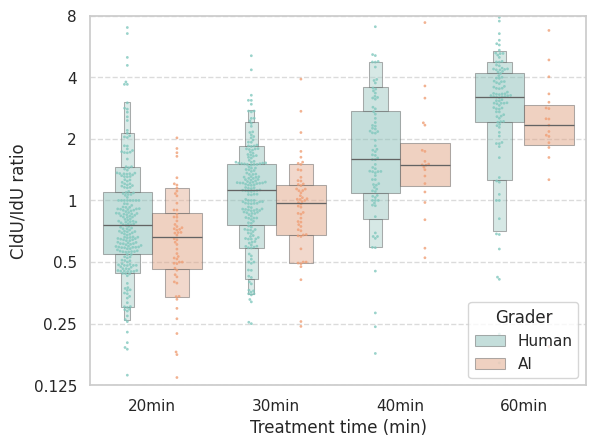

In [15]:


df = pd.DataFrame(data_with_gt)
df = df[df['Ratio']>0.125]
palette = ["#81c8be", "#ef9f76"]
df["Type"] = df["Image"]

df['Ratio'] = (1/df['Ratio'])


create_boxen_swarmplot(df, palette=palette, column="Ratio", dodge=True, size=2, rotate_xticks=0)
plt.ylim(0.125,8)
plt.ylabel("CldU/IdU ratio")
plt.xlabel("Treatment time (min)")

plt.savefig("hu_treatment_time_comparison.png", dpi=300, bbox_inches='tight')
plt.show()


In [5]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/ImageADN/1-hutreated_greenfirst_redsecond_20mineach_redexpectedshorter/")
folders = list(root.iterdir())
folders.sort(key=lambda x: x.stem)
data = dict(Ratio=[], Image=[], FirstLength=[], SecondLength=[], Length=[])
for f in tqdm(folders):
    img_filepath = f / "manualSegm/filteredIm/squelFiltered.png"
    img = cv2.imread(str(img_filepath), cv2.IMREAD_COLOR_RGB)[:, :2048]
    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False, use_tta=True)
    fibers_pred = fibers_pred.valid_copy()
    data["Ratio"] += fibers_pred.ratios
    data["FirstLength"] += fibers_pred.greens
    data["SecondLength"] += fibers_pred.reds
    data["Image"] += [root.stem] * len(fibers_pred)
    data["Length"] += fibers_pred.lengths



  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/ImageADN/2-MockTreated_GreenFirst_RedSecond_20minEach_RedExpectedEqual")
folders = list(root.iterdir())
folders = [f for f in folders if f.is_dir()]
folders.sort(key=lambda x: x.stem)
for f in tqdm(folders):
    img_filepath = f / "manualSegm/filteredIm/squelFiltered.png"
    img = cv2.imread(str(img_filepath), cv2.IMREAD_COLOR_RGB)[:, :2048]
    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False, use_tta=True)
    fibers_pred = fibers_pred.valid_copy()
    data["Ratio"] += fibers_pred.ratios
    data["Image"] += [root.stem] * len(fibers_pred)
    data["FirstLength"] += fibers_pred.greens
    data["SecondLength"] += fibers_pred.reds
    data["Length"] += fibers_pred.lengths



  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/ImageADN/3-hutreated_ssdna_greenfirst_redsecond_bluessdna_20mineach_redexpectedshorter")
folders = list(root.iterdir())
folders = [f for f in folders if f.is_dir()]
folders.sort(key=lambda x: x.stem)
for f in tqdm(folders):
    img_filepath = f / "manualSegm/filteredIm/squelFiltered.png"
    img = cv2.imread(str(img_filepath), cv2.IMREAD_COLOR_RGB)[:, :2048]
    img[:,:, 2] = 0
    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False, use_tta=True)
    fibers_pred = fibers_pred.valid_copy()
    data["Ratio"] += fibers_pred.ratios
    data["Image"] += [root.stem] * len(fibers_pred)
    data["FirstLength"] += fibers_pred.greens
    data["SecondLength"] += fibers_pred.reds
    data["Length"] += fibers_pred.lengths



  0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
root = Path("/home/clement/Documents/data/DNAFiber/Santiago/ImageADN/4-MockTreated_GreenFirst_RedSecond_15minGreen_90minRed")
folders = list(root.iterdir())
folders = [f for f in folders if f.is_dir()]
folders.sort(key=lambda x: x.stem)
for f in tqdm(folders):
    img_filepath = f / "manualSegm/filteredIm/squelFiltered.png"
    img = cv2.imread(str(img_filepath), cv2.IMREAD_COLOR_RGB)[:, :2048]
    fibers_pred = run_one_file(img, model=ENSEMBLE, pixel_size=0.06773, use_correction=False, verbose=False, use_tta=True)
    fibers_pred = fibers_pred.valid_copy()
    data["Ratio"] += fibers_pred.ratios
    data["Image"] += [root.stem] * len(fibers_pred)
    data["FirstLength"] += fibers_pred.greens
    data["SecondLength"] += fibers_pred.reds
    data["Length"] += fibers_pred.lengths


  0%|          | 0/15 [00:00<?, ?it/s]

In [9]:
for k, v in data.items():
    print(k, len(v))

Ratio 736
Image 736
FirstLength 736
SecondLength 736
Length 736


/tmp/ipykernel_1335242/3736582391.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hu["Type"] = df_hu["Image"]
/home/clement/Documents/Projets/DeepFiberQ/dnafiber/analysis/ratios.py:131: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(data=df, x="Type", y=column, hue="Grader", palette=palette, linewidth=0.75, **kwargs)
/home/clement/Documents/Projets/DeepFiberQ/dnafiber/analysis/ratios.py:150: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.swarmplot(data=df, x="Type", y=column, hue="Grader", palette=palette, **kwargs)
/home/clement/Documents/Projets/DeepFiberQ/dnafiber/analysis/ratios.py:131: UserWarning: The palette list has 

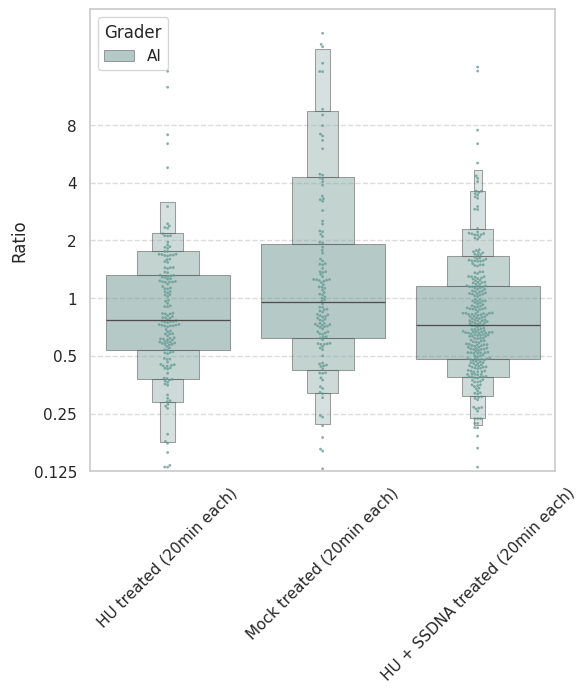

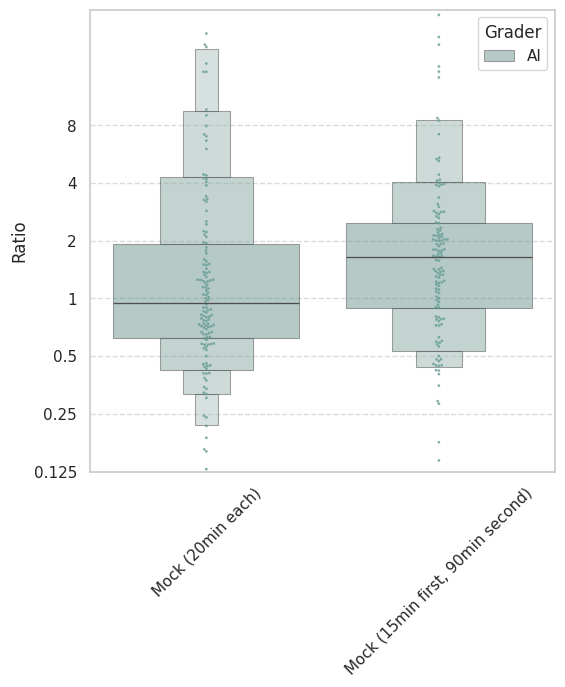

In [10]:
import numpy as np
df = pd.DataFrame(data)


df1 = df.replace(
    {
        "Image": {
            "1-hutreated_greenfirst_redsecond_20mineach_redexpectedshorter": "HU treated (20min each)",
            "2-MockTreated_GreenFirst_RedSecond_20minEach_RedExpectedEqual": "Mock treated (20min each)",
            "3-hutreated_ssdna_greenfirst_redsecond_bluessdna_20mineach_redexpectedshorter": "HU + SSDNA treated (20min each)",
            "4-MockTreated_GreenFirst_RedSecond_15minGreen_90minRed": "Mock treated (15min green, 90min Red)",
        }
    }
)
df1['Grader'] = 'AI'
df1["Ratio"] = 1 / df1["Ratio"].astype(float)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 6))

df_hu = df1[
    df1["Image"].isin(["HU treated (20min each)", "HU + SSDNA treated (20min each)", "Mock treated (20min each)", ])
]

df_hu["Type"] = df_hu["Image"]
df_hu = df_hu[df_hu["Ratio"] > 0.125]

create_boxen_swarmplot(df_hu, palette=["#659c94", "#b87c5f", "#b87c5f"], column="Ratio", dodge=True, size=2)
plt.savefig("hu_vs_mock.png", dpi=300)
plt.figure(figsize=(6, 6))

df_mock = df1[
    df1["Image"].isin(
        ["Mock treated (20min each)", "Mock treated (15min green, 90min Red)"]
    )
]
df_mock = df_mock[df_mock["Ratio"] > 0.125]
df_mock["Type"] = df_mock["Image"]
df_mock['Type'] = df_mock['Type'].replace({"Mock treated (20min each)": "Mock (20min each)", "Mock treated (15min green, 90min Red)": "Mock (15min first, 90min second)"})

create_boxen_swarmplot(df_mock, palette=["#659c94", "#b87c5f"], column="Ratio", dodge=True, size=2)
plt.savefig("mock_treatment_time_comparison.png", dpi=300)

/tmp/ipykernel_1335242/2382185881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mock["FirstLength"] = df_mock["FirstLength"].astype(float) * 0.06773


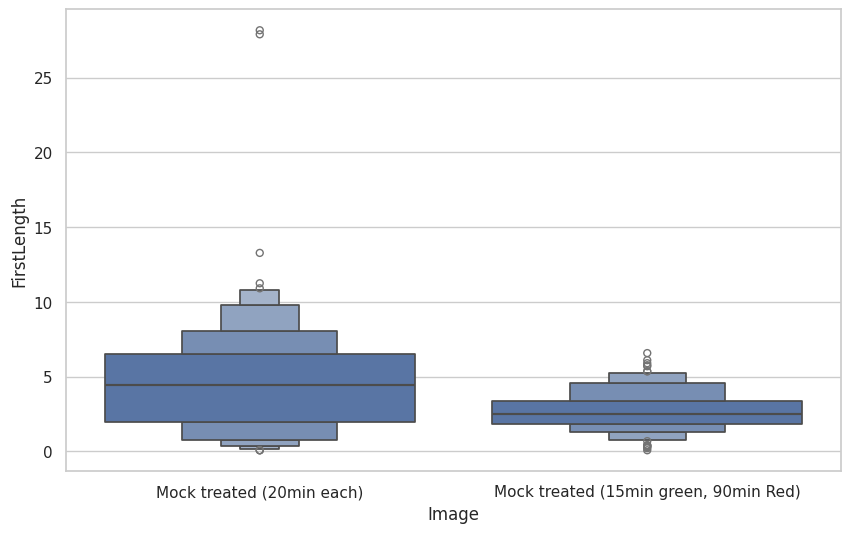

In [11]:
df_mock = df1[
    df1["Image"].isin(
        ["Mock treated (20min each)", "Mock treated (15min green, 90min Red)"]
    )
]
# df_mock = df_mock[df_mock["Ratio"] > 0.125]
plt.figure(figsize=(10, 6))
df_mock["FirstLength"] = df_mock["FirstLength"].astype(float) * 0.06773
sns.boxenplot(
    x="Image",
    y="FirstLength",
    data=df_mock,
    linewidth=1.25,
)
# plt.yscale("log")
# plt.yticks([0.125, 0.25, 0.5, 1, 2, 4, 8], [0.125, 0.25, 0.5, 1, 2, 4, 8])
# plt.minorticks_off()
# plt.ylim(0.0, 16)
# plt.xticks(rotation=45)
plt.show()

In [12]:
df_mock

,Ratio,Image,FirstLength,SecondLength,Length,Grader
166,0.406250,Mock treated (20min each),28.17568,169,585,AI
167,0.895833,Mock treated (20min each),9.75312,129,273,AI
168,0.810000,Mock treated (20min each),6.77300,81,181,AI
169,0.657895,Mock treated (20min each),7.72122,75,189,AI
170,0.574257,Mock treated (20min each),6.84073,58,159,AI
...,...,...,...,...,...,...
731,3.000000,"Mock treated (15min green, 90min Red)",1.62552,72,96,AI
732,1.390244,"Mock treated (15min green, 90min Red)",2.77693,57,98,AI
733,1.285714,"Mock treated (15min green, 90min Red)",2.84466,54,96,AI
734,3.900000,"Mock treated (15min green, 90min Red)",1.35460,78,98,AI
